In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [2]:
X_train = pd.read_csv('./X_train.csv')
X_test = pd.read_csv('./X_test.csv')

In [4]:
X_train.head()

Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Title  Name_length  \
0       3    1  22.0      1      0   7.2500         2      2            2   
1       1    0  38.0      1      0  71.2833         0      3            0   
2       3    0  26.0      0      0   7.9250         2      1            2   
3       1    0  35.0      1      0  53.1000         2      3            1   
4       3    1  35.0      0      0   8.0500         2      2            2   

   FamilySize  FsizeD  Ticket_captal  FareClass  CabinClass  AgeClass  
0         1.0       2              9          0           8       2.0  
1         1.0       2             13          7           2       3.0  
2         0.0       1             14          0           8       2.0  
3         1.0       2              0          5           2       3.0  
4         0.0       1              2          0           8       3.0

In [5]:
y_train = pd.Series(np.load('./y.npy'), name='Survived')

In [8]:
X_train.insert(loc=0, column='Survived', value=y_train.values)

In [9]:
X_train.head()

Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Title  \
0         0       3    1  22.0      1      0   7.2500         2      2   
1         1       1    0  38.0      1      0  71.2833         0      3   
2         1       3    0  26.0      0      0   7.9250         2      1   
3         1       1    0  35.0      1      0  53.1000         2      3   
4         0       3    1  35.0      0      0   8.0500         2      2   

   Name_length  FamilySize  FsizeD  Ticket_captal  FareClass  CabinClass  \
0            2         1.0       2              9          0           8   
1            0         1.0       2             13          7           2   
2            2         0.0       1             14          0           8   
3            1         1.0       2              0          5           2   
4            2         0.0       1              2          0           8   

   AgeClass  
0       2.0  
1       3.0  
2       2.0  
3       3.0  
4       3.0

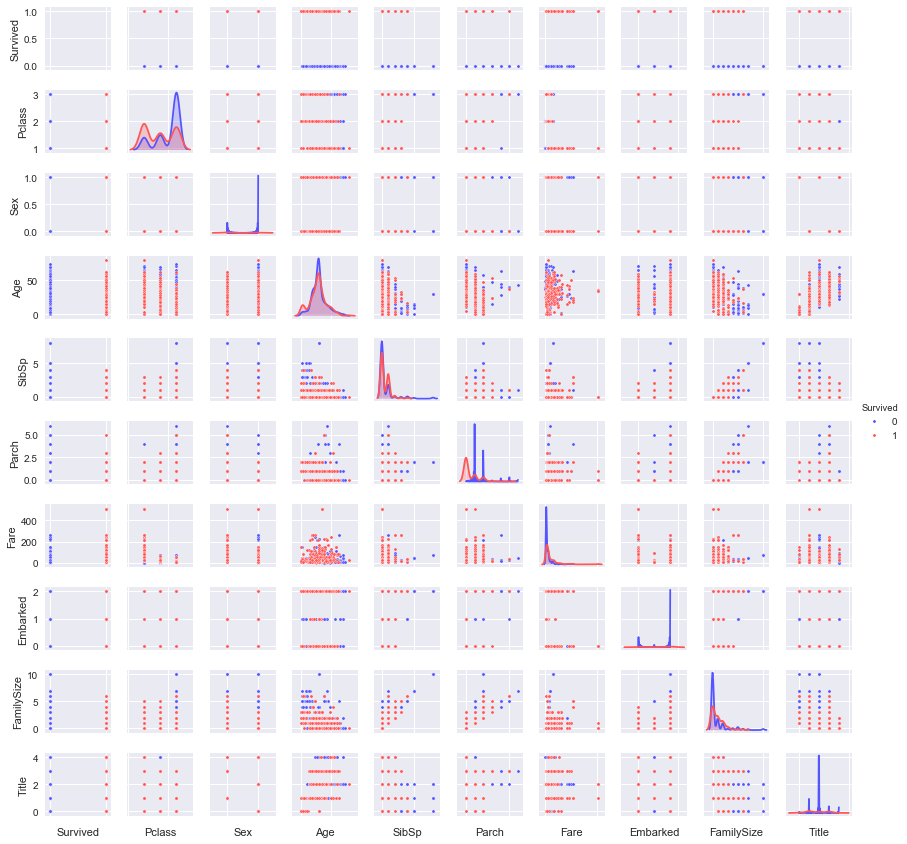

In [15]:
g = sns.pairplot(X_train[[u'Survived', u'Pclass', u'Sex', u'Age', 'SibSp', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# Ensembling & Stacking models¶


In [16]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [26]:
# Some useful parameters which will come in handy later on
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    

In [56]:
len(X_train), len(y_train), len(X_test)

(891, 891, 418)

In [57]:
def get_oof(clf, x_train, y_train, x_test):
    ntrain = len(x_train)
    ntest = len(x_test)
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    kf = StratifiedKFold(n_splits=3, shuffle=True,)

    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [58]:
# 导入所需要的分类器
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

In [59]:
rf = SklearnHelper(clf=RandomForestClassifier, params=rf_params, seed=1024)
ab = SklearnHelper(clf=AdaBoostClassifier, params=ada_params, seed=1024)
gb = SklearnHelper(clf=GradientBoostingClassifier, params=gb_params, seed=1024)
et = SklearnHelper(clf=ExtraTreesClassifier, params=et_params, seed=1024)
svc = SklearnHelper(clf=SVC, params=svc_params, seed=1024)


In [60]:
X_train = X_train.loc[:, 'Pclass':]

In [61]:
X_test.head()

Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Title  Name_length  \
0       3    1  34.5      0      0   7.8292         1      2            2   
1       3    0  47.0      1      0   7.0000         2      3            1   
2       2    1  62.0      0      0   9.6875         1      2            2   
3       3    1  27.0      0      0   8.6625         2      2            2   
4       3    0  22.0      1      1  12.2875         2      3            1   

   FamilySize  FsizeD  Ticket_captal  FareClass  CabinClass  AgeClass  
0         0.0       1              2          0           8       3.0  
1         1.0       2              2          0           8       4.0  
2         0.0       1              1          0           8       6.0  
3         0.0       1              2          0           8       2.0  
4         1.0       2              2          1           8       2.0

In [64]:
X_train.values

TypeError: 'numpy.ndarray' object is not callable

In [66]:
et_oof_train, et_oof_test = get_oof(et, X_train.values, y_train.values, X_test.values)
ab_oof_train, ab_oof_test = get_oof(ab, X_train.values, y_train.values, X_test.values)
rf_oof_train, rf_oof_test = get_oof(rf, X_train.values, y_train.values, X_test.values)
gb_oof_train, gb_oof_test = get_oof(gb, X_train.values, y_train.values, X_test.values)
svc_oof_train, svc_oof_test = get_oof(svc, X_train.values, y_train.values, X_test.values)

In [70]:
X_train_stack = np.concatenate([et_oof_train, ab_oof_train, rf_oof_train, gb_oof_train, svc_oof_train], axis=1)
X_test_stack = np.concatenate([et_oof_test, ab_oof_test, rf_oof_test ,gb_oof_test, svc_oof_test], axis=1)

In [71]:
X_train_stack.shape

(891, 5)

(418, 5)

In [74]:
import xgboost as xgb

In [ ]:
parame

In [94]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators= 3000,
    max_depth= 5,
    min_child_weight= 2,
    #gamma=1,
    gamma=0.9,                        
    subsample=0.9,
    colsample_bytree=0.9,
    objective= 'binary:logistic',
    n_jobs= -1,
    scale_pos_weight=1)

In [95]:
from sklearn.model_selection import cross_val_score, GridSearchCV

In [96]:
params = {
    "n_estimators": [1000, 2000, 3000],
    "max_depth": [4, 5, 6, 7],
    "min_child_weight": [2, 3, 4]
    
}

In [85]:
cross_val_score(estimator=gbm, X=X_train, y=y_train, cv=3, n_jobs=-1, verbose=2)

[CV]  ................................................................
[CV]  ................................................................


/Users/gjwei/anaconda/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:210: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)


[CV]  ................................................................


/Users/gjwei/anaconda/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:210: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/Users/gjwei/anaconda/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:210: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)


[CV] ................................................. , total=   2.0s
[CV] ................................................. , total=   2.0s
[CV] ................................................. , total=   2.1s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


array([ 0.81144781,  0.83838384,  0.84175084])

In [99]:
gs = GridSearchCV(estimator=gbm, cv=3, param_grid=params, verbose=2)

In [100]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] n_estimators=1000, max_depth=4, min_child_weight=2 ..............
[CV]  n_estimators=1000, max_depth=4, min_child_weight=2, total=   0.5s
[CV] n_estimators=1000, max_depth=4, min_child_weight=2 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  n_estimators=1000, max_depth=4, min_child_weight=2, total=   0.5s
[CV] n_estimators=1000, max_depth=4, min_child_weight=2 ..............
[CV]  n_estimators=1000, max_depth=4, min_child_weight=2, total=   0.5s
[CV] n_estimators=2000, max_depth=4, min_child_weight=2 ..............
[CV]  n_estimators=2000, max_depth=4, min_child_weight=2, total=   1.0s
[CV] n_estimators=2000, max_depth=4, min_child_weight=2 ..............
[CV]  n_estimators=2000, max_depth=4, min_child_weight=2, total=   0.9s
[CV] n_estimators=2000, max_depth=4, min_child_weight=2 ..............
[CV]  n_estimators=2000, max_depth=4, min_child_weight=2, total=   0.9s
[CV] n_estimators=3000, max_depth=4, min_child_weight=2 ..............
[CV]  n_estimators=3000, max_depth=4, min_child_weight=2, total=   1.4s
[CV] n_estimators=3000, max_depth=4, min_child_weight=2 ..............
[CV]  n_estimators=3000, max_depth=4, min_child_weight=2, total=   1.4s
[CV] n_estimators=3000, max_depth=4, min_child_weight=2 ..............

[CV]  n_estimators=2000, max_depth=6, min_child_weight=2, total=   1.3s
[CV] n_estimators=3000, max_depth=6, min_child_weight=2 ..............
[CV]  n_estimators=3000, max_depth=6, min_child_weight=2, total=   1.9s
[CV] n_estimators=3000, max_depth=6, min_child_weight=2 ..............
[CV]  n_estimators=3000, max_depth=6, min_child_weight=2, total=   1.9s
[CV] n_estimators=3000, max_depth=6, min_child_weight=2 ..............
[CV]  n_estimators=3000, max_depth=6, min_child_weight=2, total=   1.9s
[CV] n_estimators=1000, max_depth=6, min_child_weight=3 ..............
[CV]  n_estimators=1000, max_depth=6, min_child_weight=3, total=   0.6s
[CV] n_estimators=1000, max_depth=6, min_child_weight=3 ..............
[CV]  n_estimators=1000, max_depth=6, min_child_weight=3, total=   0.6s
[CV] n_estimators=1000, max_depth=6, min_child_weight=3 ..............
[CV]  n_estimators=1000, max_depth=6, min_child_weight=3, total=   0.6s
[CV] n_estimators=2000, max_depth=6, min_child_weight=3 ..............

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.9, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=2, missing=None,
       n_estimators=3000, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1000, 2000, 3000], 'max_depth': [4, 5, 6, 7], 'min_child_weight': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [101]:
gs.best_params_

{'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 3000}

In [102]:
gs.best_score_

0.84399551066217737

# stack

In [103]:
xgb_c = xgb.XGBClassifier(n_estimators=2000, max_depth=7, min_child_weight=4, n_jobs=-1, 
                         gamma=0.9,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective= 'binary:logistic')

In [104]:
cross_val_score(xgb_c, X=X_train_stack, y=y_train, cv=3, n_jobs=-1, verbose=2)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   0.6s
[CV] ................................................. , total=   0.6s
[CV] ................................................. , total=   0.6s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


array([ 0.85185185,  0.88552189,  0.87878788])

In [105]:
xgb_c.fit(X_train_stack, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.9, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=4, missing=None,
       n_estimators=2000, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [106]:
xgb_c.score(X_train_stack, y_train)

0.87205387205387208

In [108]:
params = {
    'max_depth': [2, 3, 4, 5 ,6, 7],
    'n_estimators': [100, 500, 1000, 1500],
    'gamma': [0, 0.2, 0.4, 0.8],
    'min_child_weight': [3, 4 ,5 ,6, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'reg_lambda': [0.3, 0.8, 1.0, 2]
}

In [109]:
xgbC = xgb.XGBClassifier(n_jobs=-1)

In [110]:
gs = GridSearchCV(estimator=xgbC, cv=3, param_grid=params, n_jobs=-1, verbose=2)

In [111]:
gs.fit(X_train_stack, y_train)

Fitting 3 folds for each of 7680 candidates, totalling 23040 fits
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0 
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0 
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0 
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.1s
[CV] min_child_weight=3, 

[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0, total=   0.0s
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0 
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0, total=   0.0s
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0 
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0,

[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.1s


[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.2s
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0 
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.2s
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, re

[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsampl

[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.7s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.8s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.8s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.8s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lam

[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=

[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0 
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0 
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   17.5s


[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg

[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsampl

[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lam

[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.0s
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0 
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_l

[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0 
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0 
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max

[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=

[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsampl

[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lam

[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0 
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, m

[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_dep

[Parallel(n_jobs=-1)]: Done 651 tasks      | elapsed:   47.4s


[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max

[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.5s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.5s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lam

[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.5s
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0 
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsampl

[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0 
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0 
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, m

[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, m

[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0, total=   0.1s
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0 
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.3s
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0 
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg

[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0, total=   0.6s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lam

[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.1s
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg

[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, m

[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.6s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lam

[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0 
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3,

[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.6s
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0 
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.

[Parallel(n_jobs=-1)]: Done 1155 tasks      | elapsed:  1.5min


[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.1s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0 
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg

[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0 
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.2s
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg

[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, re

[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth

[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.5s
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0 
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsampl

[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0 
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg

[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg

[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsampl

[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3,

[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0, total=   0.5s
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0 
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambd

[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.1s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0 
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, re

[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg

[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsampl

[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lam

[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambd

[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0 
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0 
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.

[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.2s
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_

[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed:  2.3min


[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=3, gamm

[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lam

[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsampl

[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0 
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0, total=   0.6s
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0, total=   0.6s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0 
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max

[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, m

[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0, total=   0.2s
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0 
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0,

[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, r

[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.7s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.7s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.8s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.8s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lam

[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0 
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0, total=   0.9s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0 
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max

[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, m

[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda

[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=

[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=

[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.1s
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0 
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.1s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0 
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, m

[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.2s
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0 
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.3s
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg

[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0 
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lam

[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8,

[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4

[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg

[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.1s
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0 
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, m

[Parallel(n_jobs=-1)]: Done 2579 tasks      | elapsed:  3.3min


[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0, total=   0.2s
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0 
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7,

[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_dep

[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=

[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, re

[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0 
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0, total=   0.1s
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, m

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsampl

[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.

[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambd

[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg

[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg

[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsampl

[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lam

[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_la

[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0 
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=5, gamma=

[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.2s
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0 
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_l

[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1000, subsampl

[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lam

[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_

[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0 
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.3, max

[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2, max

[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0 
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambd

[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsampl

[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0 
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0, total=   0.4s
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0 
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.8, ma

[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.3, m

[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=5, gam

[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lam

[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lam

[Parallel(n_jobs=-1)]: Done 3654 tasks      | elapsed:  4.5min


[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.0s
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0, total=   0.5s
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg

[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, m

[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lam

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=

[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, m

[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.1s
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg

[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.2s
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0 
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, m

[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lam

[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.

[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=6

[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0 
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_dep

[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, m

[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lam

[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsampl

[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.0s
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_

[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0 
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0 
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0 


[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0 
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.1s
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_dep

[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lam

[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsampl

[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0 
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, m

[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0 
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, 

[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=

[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0 
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.3s
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0 
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lamb

[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lam

[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.0s
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0, total=   0.9s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0 
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_

[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, m

[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0, total=   0.2s
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0 
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6,

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lam

[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lam

[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0 


[Parallel(n_jobs=-1)]: Done 4813 tasks      | elapsed:  5.9min


[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.2s
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0 
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg

[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0 
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.2s
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0 
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, ma

[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=3, n_estimators=1000, subsampl

[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0 
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_d

[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.8s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.7s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lam

[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0 
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg

[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg

[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.6s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.6s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1000, subsampl

[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lam

[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0, total=   0.7s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0, total=   0.7s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda

[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=

[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg

[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0 
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.5s
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lam

[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.8s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.8s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.8s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.7s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lam

[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0 
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, ma

[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0 
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0, total=   0.0s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.3, max

[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.2s
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0 
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=

[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsampl

[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.8s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.7s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.7s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lam

[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0, total=   0.8s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, ma

[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.1s
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0 
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, m

[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=7, gamma

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.4s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, r

[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0 
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lam

[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, 

[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8,

[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.1s
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000,

[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.2s
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.2 
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_

[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimator

[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.5s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, s

[Parallel(n_jobs=-1)]: Done 5982 tasks      | elapsed:  7.4min


[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambd

[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=

[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.2s
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimat

[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subs

[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7,

[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, su

[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg

[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimator

[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.6s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.7s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.7s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.6s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.7s
[CV] min_child_weight=5, n_estimat

[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, 

[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7,

[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambd

[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg

[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subs

[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.1s
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, 

[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, 

[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=

[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.3s
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.2 
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, r

[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subs

[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.0s
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, 

[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, 

[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.4s
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.3s
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimat

[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_l

[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.

[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.1s
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.1s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8,

[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, 

[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.5s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.5s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.6s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimat

[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500

[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_l

[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9,

[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, 

[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=5, n_estimat

[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.6s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.7s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.9s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.9s
[CV] min_child_weight=5, n_estimator

[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.6s
[CV] min_child_weight=5, n_estimators=1500, subsampl

[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, su

[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7,

[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.5s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subs

[Parallel(n_jobs=-1)]: Done 7426 tasks      | elapsed:  9.0min


[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsampl

[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.4s
[CV]  min_child_weight=6, n_estimators

[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, 

[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.1s
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8,

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimat

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1500, su

[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, 

[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.1s
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV] min_child_weight=3, n_estimators=100, 

[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0,

[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subs

[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsam

[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lam

[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, r

[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, 

[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.3s
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsa

[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.7s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.7s
[CV] min_child_weight=4, n_estimat

[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.2, total=   1.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.8s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.7s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.5s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.1s
[CV]  min_child_weight=4, n_estimators=1500, subsa

[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.2 
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsamp

[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9,

[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subs

[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.6s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.6s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subs

[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.0s
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, 

[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.1s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, r

[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.2s
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, su

[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.5s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimat

[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimat

[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, su

[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, r

[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsam

[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.3s
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimat

[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimat

[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.0s
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.2, total=   0.3s
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV] min_child_weight=3, n_estimators=100, s

[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8,

[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=

[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimat

[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.7s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.7s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.6s
[CV] min_child_weight=3, n_estimat

[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, 

[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg

[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=2, max

[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsam

[Parallel(n_jobs=-1)]: Done 8961 tasks      | elapsed: 10.9min


[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsampl

[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimat

[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, 

[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.1s
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, 

[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.4s
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.3s
[CV]  min_child_weight=5, n_estima

[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.3s
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.2 
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1500, 

[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.

[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7,

[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, 

[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimat

[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500

[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.6s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.6s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_l

[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9,

[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, 

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimat

[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsa

[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subs

[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.1s
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.2 
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subs

[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.2s
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, 

[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.3s
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subs

[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subs

[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.5s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsamp

[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambd

[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, 

[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimat

[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimat

[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.5s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, s

[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.2 
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.2 
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=2, ma

[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg

[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.3s
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subs

[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.4s
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subs

[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, 

[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.2 
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, m

[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambd

[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subs

[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.3s
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subs

[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, re

[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.2 
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3

[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambd

[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.2s
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subs

[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subs

[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7,

[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subs

[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, r

[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=3, n_estimators=10

[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.5s
[CV] min_child_weight=3, n_estimat

[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, 

[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7,

[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.1s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2

[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, r

[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subs

[Parallel(n_jobs=-1)]: Done 10926 tasks      | elapsed: 13.0min


[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.6s
[CV] min_child_weight=4, n_estimators=15

[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, 

[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0,

[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subs

[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8,

[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.4s
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.2 
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_l

[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.1s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8,

[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, 

[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimat

[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimator

[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsampl

[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, re

[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.1s
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8,

[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1000, subs

[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subs

[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.2 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.3s
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.2, total=   0.4s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_la

[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.0s
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.0s
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.4 
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4 
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.0s
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.0s
[CV]  min_child_weight=3, n_estimators=100, subsample=0

[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, 

[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimat

[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.3s
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV] min_child_weight=3, n_estimat

[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.4s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, s

[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, r

[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.1s
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4 
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg

[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subs

[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.4s
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subs

[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.4s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.5s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, r

[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.4 
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=2, max

[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4 
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.1s
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=

[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subs

[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subs

[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.6s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, s

[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.1s
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.4 
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=

[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.4s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.4s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.2s
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.

[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.6s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.6s
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.7s
[CV] min_child_weight=6, n_estimat

[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.3s
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subs

[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, 

[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subs

[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.1s
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, r

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=

[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimat

[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.0s
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, 

[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.2s
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, 

[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, 

[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.

[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subs

[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9,

[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, 

[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.1s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8

[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.3s
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.4 
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg

[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.6s
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subs

[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.1s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0,

[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, 

[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.3s
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subs

[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.4s
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsamp

[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.8s
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.7s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.7s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.7s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=

[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7,

[Parallel(n_jobs=-1)]: Done 13087 tasks      | elapsed: 15.2min


[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.0s
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.1s
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subs

[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.4s
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.4 
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=2,

[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsampl

[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.7s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.9s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.9s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subs

[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8,

[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, 

[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=1000, subsample=0

[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.4 
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_

[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimat

[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.1s
[CV]  min_child_weight=3, n_estimators=100,

[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0,

[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.2s
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, su

[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subs

[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.8s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.8s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.7s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.7s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.7s
[CV] min_child_weight=3, n_estimat

[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.1s
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, 

[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.2s
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7,

[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.4s
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=4, n_estimat

[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=4, n_estimators=1000, subsampl

[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.5s
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.4 
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=

[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, 

[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.2s
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9,

[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.3s
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimat

[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.3s
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1500, 

[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.5s
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4 
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg

[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, 

[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, 

[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimat

[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=6, n_estimators=

[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lam

[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.1s
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, 

[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.1s
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.4 
[CV] min_child_weight=7, n_estimators=500, 

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimat

[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.7s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.6s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.4, total=   0.6s
[CV] min_child_weight=7, n_estimators=1500, subsa

[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.6s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.6s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.4, total=   0.5s
[CV] min_child_weight=3, n_estimators=100, subsample

[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.1s
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4 
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.0s
[CV]  min_child_weight=3, n_estimators=100, subsa

[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.2s
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, 

[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.4s
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimat

[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.6s
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.6s
[CV]  min_child_weight=3, n_estima

[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.6s
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=100, subsa

[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.1s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.4 
[CV] min_child_weight=4, n_estimators=500, subsample=0.7,

[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.2s
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4 
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, r

[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.5s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.5s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subs

[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.7s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subs

[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.5s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, 

[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.4 
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, m

[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.2s
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.4 
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg

[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subs

[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.7s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.7s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.6s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subs

[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9,

[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2,

[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4 


[Parallel(n_jobs=-1)]: Done 15045 tasks      | elapsed: 17.9min


[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.

[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimat

[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.5s
[CV] min_child_weight=6, n_estimat

[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, 

[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_l

[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.2s
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.4 
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, m

[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subs

[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.6s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.4, total=   0.6s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subs

[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.0s
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, 

[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.2s
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, 

[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.2s
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.4 
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg

[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.5s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=10

[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   1.1s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   1.1s
[CV] min_child_weight=3, n_estimat

[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8,

[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9,

[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.2s
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lamb

[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg

[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subs

[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0,

[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, 

[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.1s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsamp

[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_l

[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.5s
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.5s
[CV] min_child_weight=5, n_estimat

[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, 

[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, 

[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subs

[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.5s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.5s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9,

[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, r

[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0

[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, 

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimat

[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.2s
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=15

[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.4, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_l

[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.0s
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0,

[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.2s
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, 

[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimat

[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.7s
[CV] min_child_weight=3, n_estimat

[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsampl

[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.4 
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subs

[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9,

[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1000, subs

[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subs

[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.5s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.6s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_

[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.1s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.4 
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.4 
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=

[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.2s
[CV]  min_child_weight=5, n_estimators=500,

[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=5, n_estimat

[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   1.0s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   1.1s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   1.0s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.9s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   1.1s
[CV] min_child_weight=5, n_estimat

[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.4s
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, s

[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.4 
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, r

[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subs

[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimat

[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsa

[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.4, total=   0.0s
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=6, n_estimators=1500, s

[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.4 
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=2, ma

[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.4 
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.4 


[Parallel(n_jobs=-1)]: Done 17204 tasks      | elapsed: 20.7min


[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.4, total=   0.2s
[CV] min_child_weight=7, n_estimat

[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.4 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=7, n_estimat

[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.4, total=   0.4s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, r

[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.1s
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subs

[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.8 
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.1s
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.8 
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, m

[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsampl

[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subs

[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8,

[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.1s
[CV]  min_child_weight=4, n_estimators=500,

[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, re

[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=4, n_estimators=1000

[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1500, subsa

[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9,

[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.2s
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0,

[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.1s
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=1000, su

[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=1000, subs

[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimat

[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, 

[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8,

[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimat

[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsampl

[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=15

[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.1s
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100,

[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=2, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9,

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.5s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.5s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.5s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.5s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimat

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.4s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, su

[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=2, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=2, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg

[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9,

[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.2s
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=500, 

[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimat

[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.8s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   1.0s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   1.0s
[CV] min_child_weight=3, n_estimators=

[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lam

[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.8 
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg

[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, 

[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.3s
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimat

[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimat

[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=100, subsample

[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsam

[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9,

[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.3s
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subs

[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subs

[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.4s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subs

[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.8 
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9,

[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.2s
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, 

[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subs

[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.4s
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subs

[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.9s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, 

[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.1s
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg

[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subs

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=7, n_estimator

[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.8, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=3, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=3, gamma=0.8, total=   0.4s
[CV] min_child_weight=7, n_estimat

[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.0s
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=3, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.0s
[CV]  min_child_weight=3, n_estimators=100, 

[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8 
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=2, ma

[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambd

[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.3s
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subs

[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.6s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subs

[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0,

[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsampl

[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8,

[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.3s
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.8 
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=

[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimat

[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, 

[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8,

[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.1s
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8 
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2,

[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.3s
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.8 
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, r

[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subs

[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8,

[Parallel(n_jobs=-1)]: Done 19812 tasks      | elapsed: 23.3min


[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.2s
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, 

[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, 

[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000

[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimat

[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=4, gamma=0.8, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100,

[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7,

[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, su

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=4, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subs

[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=4, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=4, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimat

[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, 

[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0,

[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.4s
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=3, n_estimat

[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsampl

[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.6s
[CV] min_child_weight=3, n_estimators=

[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, 

[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV] min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.2s
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8,

[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimat

[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, su

[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.6s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg

[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.6s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, 

[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, 

[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.3s
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimat

[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.8 
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.4s
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.6s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.6s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=5, n_estimators=1500, subsample

[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsampl

[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, re

[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.1s
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9,

[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subs

[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subs

[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.8 
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_la

[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.1s
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV] min_child_weight=7, n_estimators=100, subsampl

[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, 

[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=5, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsa

[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.5s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=5, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=5, gamma=0.8, total=   0.4s
[CV] min_child_weight=7, n_estimat

[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=5, gamma=0.8, total=   0.4s
[CV]  min_child_weight=3, n_estimators=100, s

[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.1s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, r

[CV] min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, r

[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.3s
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimat

[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subs

[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.5s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.5s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.0s
[CV]  min_child_weight=3, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, re

[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.8 
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=2, max

[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.1s
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg

[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.3s
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subs

[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subs

[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.5s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, 

[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.0s
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.8 
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=2,

[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambd

[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subs

[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subs

[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100,

[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_la

[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=500, subsample=1.0,

[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimator

[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimat

[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.6s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, s

[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=6, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8,

[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=2, max

[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.

[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.8, max_depth=6, gamma=0.8, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=6, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=6, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subs

[CV] min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.0s
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=3, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=100, subsample=0.9,

[CV]  min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, 

[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=3, n_estimators=1000, subsampl

[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=3, n_estimators=1000, 

[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.5s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=3, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=3, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=3, n_estimat

[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.0s
[CV]  min_child_weight=4, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=4, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV] min_child_weight=4, n_estimators=100, 

[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.1s
[CV] min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=4, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=500, subsample=1.0,

[CV]  min_child_weight=4, n_estimators=500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators

[CV]  min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1000, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=4, n_estimators=1000, subsam

[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=4, n_estimators=1500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=4, n_estimators=

[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=5, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV] min_child_weight=5, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=100, subsample=1.0,

[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.1s
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.1s
[CV] min_child_weight=5, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV] min_child_weight=5, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=500, subsample=0.8,

[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV] min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV] min_child_weight=5, n_estimat

[Parallel(n_jobs=-1)]: Done 22566 tasks      | elapsed: 26.3min


[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=5, n_estimat

[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1000, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.3s
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimator

[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.8 
[CV] min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.4s
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=5, n_estimators=1500, subsample=0.9, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=5, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.4s
[CV]  min_child_weight=5, n_estimators=1500, subsa

[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.0s
[CV]  min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.8 
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV] min_child_weight=6, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=6, n_estimators=100, subs

[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV] min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=500, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.1s
[CV] min_child_weight=6, n_estimators=500, subsample=0.9, 

[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1000, subs

[CV] min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.4s
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subs

[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=6, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=6, n_estimators=1500, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg

[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=1.0, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.0s
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.0s
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.8 
[CV] min_child_weight=7, n_estimators=100, subsample=0.8, reg_lambda=2, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=100, subsample=0.7, reg_lambda=

[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.8, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.7, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.1s
[CV] min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=500, subsample=0.9, reg_lambda=1.0, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=500, 

[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.8, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.2s
[CV] min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1000, subsample=0.9, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1000, subsample=1.0, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimat

[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.9, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8, total=   0.3s
[CV] min_child_weight=7, n_estimators=1500, subsample=0.7, reg_lambda=0.8, max_depth=7, gamma=0.8 
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=0.3, max_depth=7, gamma=0.8, total=   0.4s
[CV] min_child_weight=7, n_estimators=1500, subsa

[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.4s
[CV]  min_child_weight=7, n_estimators=1500, subsample=1.0, reg_lambda=2, max_depth=7, gamma=0.8, total=   0.2s


[Parallel(n_jobs=-1)]: Done 23040 out of 23040 | elapsed: 26.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_child_weight': [3, 4, 5, 6, 7], 'n_estimators': [100, 500, 1000, 1500], 'subsample': [0.7, 0.8, 0.9, 1.0], 'reg_lambda': [0.3, 0.8, 1.0, 2], 'max_depth': [2, 3, 4, 5, 6, 7], 'gamma': [0, 0.2, 0.4, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)